# X-Ray Image Classification of Pneumonia in Pediatric Patients

<img src="images/title image.jpeg" style="width: 600px;">

## Overview

This project explores a dataset of x-ray images from pediatric patients with/without pneumonia. Pneumonia is a very common inflammatory condition that is found in the lungs, primarily in the air sacs when filled with fluid or pus. Symptoms can include cough, fever, chills, and difficulty breathing. Pneumonia can be life-threatening, but particularly to infants, children and people over the age of 65 ([Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204)). 

The images in the dataset were selected from cohorts of patients from one to five years old from Guangzhou Women and Children's Medical Center. The data was provided by Kermany et al. on Mendeley through [Kaggle datasets](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). All the chest x-ray images were screened for quality control, and then the diagnoses of the images were graded by two expert physicians before cleared for training. This notebook outlines the implementation of neural network models and how it can help classify whether or not a given patient has pneumonia, given a chest x-ray image. 

## Business Understanding

The Children's Medical Center has asked for assistance on exploring whether partially automating the diagnosis of pneumonia in their pediatric patients is possible. Rather than finding the best possible accuracy on a model, a deep neural network that has been clearly iterated on can help our understanding of how these models and automations work and if it can help doctors confidently and efficiently diagnosis pneumonia. Broadly speaking, this can also help our understanding of AI learning and its implementation in other parts of the medical field. The Children's Medical Center hopes to gain more understanding of supervised learning and it's potential use case in diagnosis.

## Data Understanding

The data was organized into three folders: train, test, and val. Each folder contains sub-folders labeled as two categories, normal and pneumonia. Within the train set there are 5216 images between the two classes, 624 in test and only 16 images in val. As previously mentioned, the diagnoses for the images were graded by two expert physicians before being cleared. In addition, in case of any grading errors, the evaluation set was also checked by a third expert. 

Since the val set contained very few images, to better balance the validation set, I randomly selected images from the test folder and moved them to the respective class within val. The data_split notebook linked in this repository outlines this process. Also by using data augmentation, the redistribution of the test images into the validation set can be seen in the output.

Since the goal of this analysis is not to build the best model possible, the goal is to demonstrate an understanding of a working model. With the dataset being quite large, only training on a portion of the dataset will allow me to run models in a reasonable time. In this section, I start by getting the paths to each directory and sub-directories of the data to take a look at the distribution between classes and some visualizations.

In [1]:
#imports
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import cv2

from sklearn import metrics
from sklearn.metrics import accuracy_score
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from imageio import imread

import tensorflow as tf
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
#creating path to the respective folder for each set
data_path = os.path.join('chest-xray-pneumonia', 'chest_xray')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
val_path = os.path.join(data_path, 'val')

In [3]:
#getting path to normal and pneumonia sub-directories
train_norm_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

#checking path
print(train_norm_path)
print(train_pneumonia_path)

chest-xray-pneumonia/chest_xray/train/NORMAL
chest-xray-pneumonia/chest_xray/train/PNEUMONIA


In [4]:
#https://stackoverflow.com/questions/57451177/python3-create-list-of-image-in-a-folder
#making a list of all the images
train_normal = Path(train_norm_path).glob('*.jpeg')
train_pneumonia = Path(train_pneumonia_path).glob('*.jpeg')

#now, looping through the above lists to append to a new list that will contain all cases in training data
train_df = []
for img in train_normal:
    train_df.append((img,0)) # label 0 is for normal cases
for img in train_pneumonia:
    train_df.append((img,1)) # label 1 is for pneumonia cases
    
train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)

#checking first few rows of the training dataframe
train_df.head()

,image,label
0,chest-xray-pneumonia/chest_xray/train/NORMAL/N...,0
1,chest-xray-pneumonia/chest_xray/train/NORMAL/N...,0
2,chest-xray-pneumonia/chest_xray/train/NORMAL/I...,0
3,chest-xray-pneumonia/chest_xray/train/NORMAL/N...,0
4,chest-xray-pneumonia/chest_xray/train/NORMAL/I...,0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


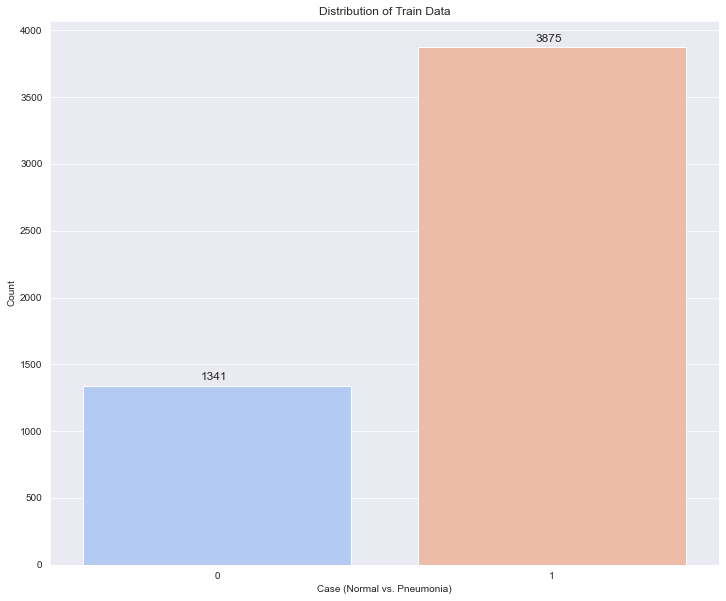

In [5]:
#visualizing data distribution in train set
plt.figure(figsize=(12, 10))
sns.set_style("darkgrid")

ax = sns.countplot(train_df['label'], palette = 'coolwarm')
ax.set(xlabel="Case (Normal vs. Pneumonia)", ylabel="Count")
#adding the count total above each label
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.35, p.get_height()+40), fontsize = 12)
    
plt.title('Distribution of Train Data', fontsize=12)
plt.show()

In [6]:
#same steps as above to visualize test data distribution
#getting path to normal and pneumonia sub-directories
test_norm_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')


test_normal = Path(test_norm_path).glob('*.jpeg')
test_pneumonia = Path(test_pneumonia_path).glob('*.jpeg')

#now, looping through the above lists to append to a new list that will contain all cases in test data
test_df = []
for img in test_normal:
    test_df.append((img,0)) # label 0 is for normal cases
for img in test_pneumonia:
    test_df.append((img,1)) # label 1 is for pneumonia cases
    
test_df = pd.DataFrame(test_df, columns=['image', 'label'], index=None)

#checking first few rows of the training dataframe
test_df.head()

,image,label
0,chest-xray-pneumonia/chest_xray/test/NORMAL/IM...,0
1,chest-xray-pneumonia/chest_xray/test/NORMAL/NO...,0
2,chest-xray-pneumonia/chest_xray/test/NORMAL/IM...,0
3,chest-xray-pneumonia/chest_xray/test/NORMAL/NO...,0
4,chest-xray-pneumonia/chest_xray/test/NORMAL/NO...,0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


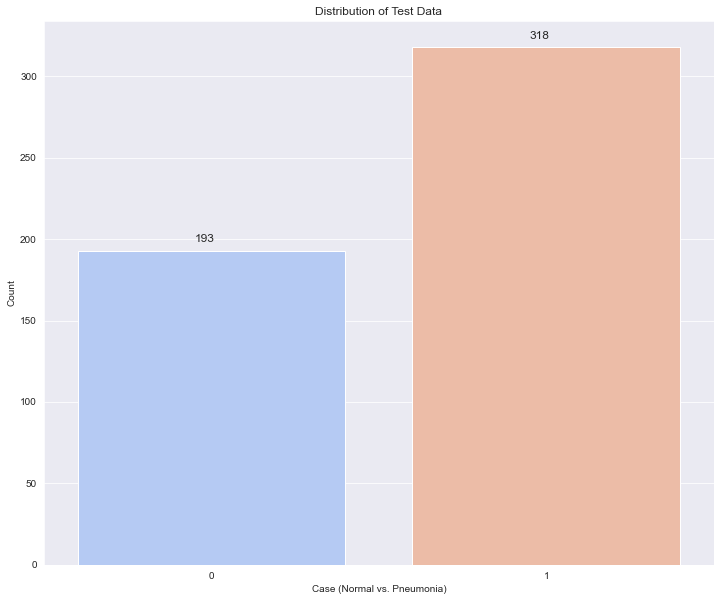

In [7]:
#visualizing data distribution in test set
plt.figure(figsize=(12, 10))
sns.set_style("darkgrid")

ax = sns.countplot(test_df['label'], palette = 'coolwarm')
ax.set(xlabel="Case (Normal vs. Pneumonia)", ylabel="Count")
#adding the count total above each label
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.35, p.get_height()+5), fontsize = 12)
    
plt.title('Distribution of Test Data', fontsize=12)
plt.show()

Both the training and test data appear slightly imbalanced, with more instances of positive/pneumonia cases compared to normal. Data augmentation will help balance the distribution, this will be done in the data preparation section below. Lastly in this section, I took a look at sample images of normal versus pneumonia cases in the training data.

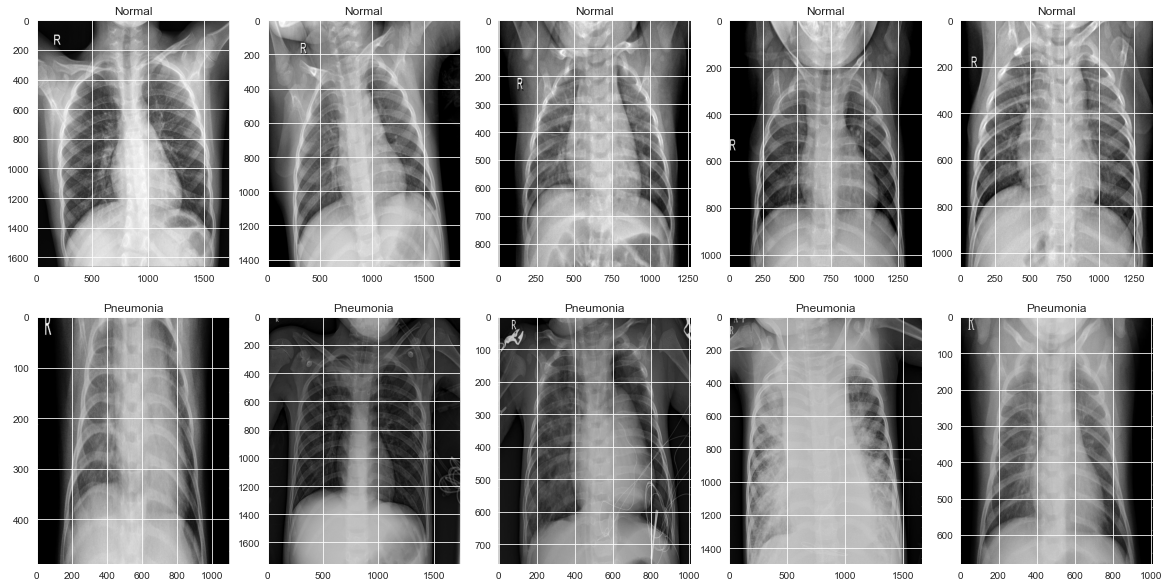

In [8]:
#https://stackoverflow.com/questions/37593901/select-rows-randomly-based-on-condition-pandas-python
#https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution?scriptVersionId=4028995&cellId=12

#sampling 5 images from each label in the training data
norm_sample = train_df.query('(label == 0)').sample(n=5)
pneumonia_sample = train_df.query('(label ==1)').sample(n=5)

#then combining the two into one list of samples
norm_list = norm_sample['image'].tolist()
pneu_list = pneumonia_sample['image'].tolist()
samples = norm_list + pneu_list

#creating plot for images
f, ax = plt.subplots(2, 5, figsize=(20, 10))
#looping through range of the number of images to display
for i in range(10):
    img = imread(samples[i])
    ax[i//5,i%5].imshow(img, cmap='gray')
    if i <5:
        ax[i//5,i%5].set_title("Normal")
    else:
        ax[i//5,i%5].set_title("Pneumonia")
    ax[i//5,i%5].set_aspect('auto')
plt.show()

It is not surprising that to an untrained eye, it is difficult to differentiate whether or not an x-ray displays a patient with pneumonia or not. 

## Data Preparation

Prior to modeling, I prepare the data by loading them from the folders. By using data augmentation through Keras' Image Data Generator, I can apply random transformations on images in our training data as it is passed through the models. This helps make the models more robust and saves on memory. It also prevents overfitting and handling any imbalances in the dataset by increasing the dataset size and specifically in the minority class. I can utilize different parameters and arguments to augment the data. There are two different generators, one used for the train data and the other for test and validation. This is because augmentation is to help the model generalize and when evaluating the model, it will utilize the actual images rather than transformed ones.

In [9]:
#https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

#instatiate ImageDataGenerator for train and test/val and then pass through each path to the 3 datasets
train_datagen = ImageDataGenerator(rescale=1 / 255.0, #normalizing image since pixel values are between 0-255
                                   rotation_range=20, 
                                   zoom_range=0.2, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_gen = train_datagen.flow_from_directory(train_path,
                                        target_size=(200, 200), #dimensions to resize the images
                                        color_mode='grayscale',
                                        shuffle=True, #whether or not to shuffle data
                                        seed=42, #random seed for applying augmentation and shuffling
                                        class_mode='binary',
                                        batch_size=32) #number of images to be yielded per batch
test_gen = test_datagen.flow_from_directory(test_path,
                                       target_size=(200, 200),
                                       color_mode='grayscale',
                                       shuffle=False,
                                       seed=42,
                                       class_mode='binary',
                                       batch_size=1)
val_gen = test_datagen.flow_from_directory(val_path,
                                      target_size=(200, 200),
                                      color_mode='grayscale',
                                      shuffle=False,
                                      seed=42,
                                      class_mode='binary',
                                      batch_size=32)

Found 5216 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


(32, 200, 200, 1)
(200, 200, 1)


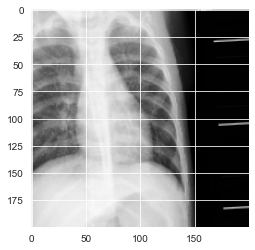

In [10]:
#https://stackoverflow.com/questions/62944529/how-can-i-plot-random-images-loaded-with-imagedatagenerator

#displaying an example image from train generator to see how it transformed
#also displaying the shape to ensure 4-D tensors as input for modeling
batch=next(train_gen)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.imshow(img, cmap='gray');   # shows the first image

## Modeling

Since these images in the dataset are x-rays, they are a little more complex than simple images which is typically better suited for Multi-Layer Perceptrons (MLP). Even though both MLP and Convolutional Neural Networks (CNN) can be used for image classification, CNNs take tensors as input, which allow CNNs to understand relations between pixels better. 
After running a model with only dense layers, I use this as a baseline to compare a shallow CNN, a deeper CNN, and lastly, transfer learning, which utilizes a pre-trained deep learning model. 

### Baseline Model

The baseline is a simple model with only dense layers.

In [11]:
#baseline model (helpful code from Joél's study group)
def baseline_model():
    layers = [
        Input(shape=(200,200,1)), #input shape (width, height, color channel)
        Flatten(), #converts data into 1-D array for inputting to next layer
        Dense(100, activation='relu'), #first hidden layer with 100 units/neurons
        Dense(1, activation='sigmoid'), #output layer as 1 unit for binary classification
    ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', #gradient descent, moving average
                  metrics=['accuracy'])
    return model

In [12]:
#initialize the model
model_1 = baseline_model()

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4000100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,000,201
Trainable params: 4,000,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
#first getting the step sizes
step_size_train = train_gen.n // train_gen.batch_size  #length of train divided by batch size
step_size_val = val_gen.n // val_gen.batch_size  #length of val divided by batch size

#fitting the model and save to results
results_1 = model_1.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        steps_per_epoch=step_size_train,
                        validation_steps=step_size_val)

Epoch 1/10
163/163 [==============================] - 56s 340ms/step - loss: 1.0079 - accuracy: 0.7111 - val_loss: 0.6172 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 50s 304ms/step - loss: 0.5561 - accuracy: 0.7506 - val_loss: 0.5818 - val_accuracy: 0.7031
Epoch 3/10
163/163 [==============================] - 50s 304ms/step - loss: 0.5345 - accuracy: 0.7638 - val_loss: 0.8955 - val_accuracy: 0.6172
Epoch 4/10
163/163 [==============================] - 49s 302ms/step - loss: 0.5231 - accuracy: 0.7678 - val_loss: 0.8612 - val_accuracy: 0.6172
Epoch 5/10
163/163 [==============================] - 50s 306ms/step - loss: 0.5348 - accuracy: 0.7636 - val_loss: 0.5612 - val_accuracy: 0.7188
Epoch 6/10
163/163 [==============================] - 50s 308ms/step - loss: 0.4854 - accuracy: 0.7789 - val_loss: 0.5394 - val_accuracy: 0.7344
Epoch 7/10
163/163 [==============================] - 49s 303ms/step - loss: 0.4884 - accuracy: 0.7774 - val_loss: 0.5327 - val_ac

In [15]:
#visually inspecting model performance
#creating a visualization function to use from here on out (helpful code from Flatiron Image Classification Lab)

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val', 'train'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val', 'train'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

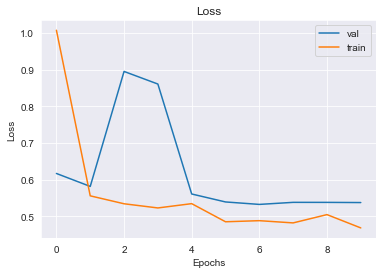

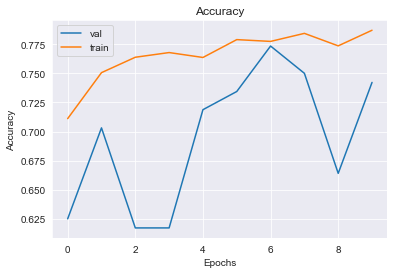

In [16]:
visualize_training_results(results_1)

In [17]:
#evaluating model performance on test data
test_loss, test_score = model_1.evaluate(test_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)                                         

511/511 [==============================] - 3s 7ms/step - loss: 0.5026 - accuracy: 0.7241
Loss on test set:  0.5025540590286255
Accuracy on test set:  0.7240704298019409


In [18]:
#display scores on val data
test_loss, test_score = model_1.evaluate(val_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score) 

5/5 [==============================] - 1s 87ms/step - loss: 0.5373 - accuracy: 0.7442
Loss on test set:  0.5372853875160217
Accuracy on test set:  0.7441860437393188


The validation scores are not higher than the training scores, which means it is likely that the baseline model is overfit to the training data. Additionally, the val scores jump around much more than the training.

### Basic Convolutional Neural Network (CNN) Model

What are CNNs? 
A CNN is a neural network with [convolutional layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/). CNNs work by using linear algebra to identify patterns using pixel values. It uses a small matrix, or better known as a kernel or filter, and moves across the image, multiplying them together each time it moves. When the filter convolves over an image, a resulting matrix is produced called a feature map. The map shows where each feature pattern is in the image. To start the iterative process, a shallow CNN model is implemented. In addition to dense layers, a convolutional layer is added alongside [max pooling](https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9#:~:text=Average%20pooling%20method%20smooths%20out,lighter%20pixels%20of%20the%20image.), which selects the brighter pixels from the image. It is useful in this case, since x-rays typically have a dark background and we are interested in the lighter pixels.

In addition, defining callbacks such as EarlyStopping helps to avoid overfitting the model. It stops the epochs based on a metric, which is val_loss in this case and is the minimum. Patience tells the model that after a minimum val_loss is reached then after that in the next 3 iterations, if the val_loss increases then the training will stop at that epoch. The learning rate reduction is a metric used to monitor the model's learning rate, and if no improvement is seen for a number of epochs, the learning rate is reduced.

In [18]:
#https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a
#setting callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduc = ReduceLROnPlateau(monitor='val_loss',
                                                  patience=2,
                                                  verbose=1,
                                                  factor=0.2,
                                                  min_lr=0.000001)

In [19]:
#assigning class weights- emphasizes the weight of the minority class in order for the model to learn from all classes equally
weights = compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)
cw = dict(zip(np.unique(train_gen.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [20]:
def conv_1():
    layers = [
        Input(shape=(200,200,1)),
        Conv2D(32, (3, 3), activation='relu'), #convolutional layer
        MaxPooling2D((2, 2)), #helps extract low-level features
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [21]:
model_2 = conv_1()

In [22]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               40145024  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 40,145,473
Trainable params: 40,145,473
Non-trainable params: 0
_________________________________________________________________


In [23]:
results_2 = model_2.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        steps_per_epoch=step_size_train,
                        validation_steps=step_size_val,
                        class_weight=cw,
                        callbacks=[early_stop, learning_rate_reduc])

Epoch 1/10
163/163 [==============================] - 88s 535ms/step - loss: 0.6978 - accuracy: 0.7418 - val_loss: 0.6233 - val_accuracy: 0.7422
Epoch 2/10
163/163 [==============================] - 107s 658ms/step - loss: 0.3025 - accuracy: 0.8616 - val_loss: 0.3938 - val_accuracy: 0.8359
Epoch 3/10
163/163 [==============================] - 100s 613ms/step - loss: 0.2877 - accuracy: 0.8740 - val_loss: 0.4107 - val_accuracy: 0.8516
Epoch 4/10
163/163 [==============================] - 109s 667ms/step - loss: 0.2897 - accuracy: 0.8775 - val_loss: 0.4517 - val_accuracy: 0.8359

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/10
163/163 [==============================] - 98s 603ms/step - loss: 0.2315 - accuracy: 0.8988 - val_loss: 0.5047 - val_accuracy: 0.8281


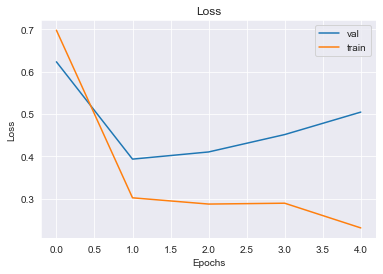

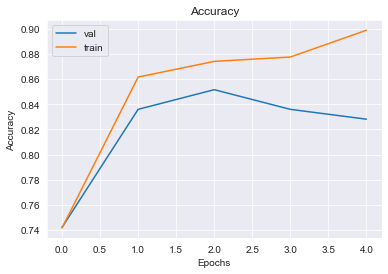

In [24]:
visualize_training_results(results_2)

In [25]:
test_loss, test_score = model_2.evaluate(test_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)      

511/511 [==============================] - 9s 17ms/step - loss: 0.4090 - accuracy: 0.8669
Loss on test set:  0.4089809060096741
Accuracy on test set:  0.8669275641441345


In [56]:
test_loss, test_score = model_2.evaluate(val_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score) 

5/5 [==============================] - 1s 134ms/step - loss: 0.5008 - accuracy: 0.8295
Loss on test set:  0.5007878541946411
Accuracy on test set:  0.8294573426246643


Again, the validation scores are not higher than training; however, the learning curves are less sporadic and shows a more even increase/decrease. Overall, the accuracy was higher and loss was less in the test set compared to the baseline model.

### Deeper CNN Model

For this iteration, I added more [convolutional layers](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/) with differing number of filters between each. It is common practice in CNN architectures where as the output spatial volume is decreasing, the number of filters learned is increasing. In addition, powers of 2 is usually recommended as the filter values. The second parameter in the Conv2D class is the kernel size, which specifies the width and height of the 2D convolution window.

In [58]:
def conv_2():
    layers = [
        Input(shape=(200, 200, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [59]:
model_3 = conv_2()

In [60]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 67712)            

In [61]:
results_3 = model_3.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        steps_per_epoch=step_size_train,
                        validation_steps=step_size_val,
                        class_weight=cw,
                        callbacks=[early_stop, learning_rate_reduc])

Epoch 1/10
163/163 [==============================] - 147s 900ms/step - loss: 0.4751 - accuracy: 0.7377 - val_loss: 0.5875 - val_accuracy: 0.6953
Epoch 2/10
163/163 [==============================] - 138s 843ms/step - loss: 0.3500 - accuracy: 0.8413 - val_loss: 0.8114 - val_accuracy: 0.6797
Epoch 3/10
163/163 [==============================] - 143s 877ms/step - loss: 0.3087 - accuracy: 0.8537 - val_loss: 0.4307 - val_accuracy: 0.7969
Epoch 4/10
163/163 [==============================] - 144s 883ms/step - loss: 0.2616 - accuracy: 0.8905 - val_loss: 0.4436 - val_accuracy: 0.8047
Epoch 5/10
163/163 [==============================] - 148s 909ms/step - loss: 0.2541 - accuracy: 0.8946 - val_loss: 0.4491 - val_accuracy: 0.8047

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
163/163 [==============================] - 146s 897ms/step - loss: 0.2221 - accuracy: 0.9074 - val_loss: 0.3991 - val_accuracy: 0.8203
Epoch 7/10
163/163 [======================

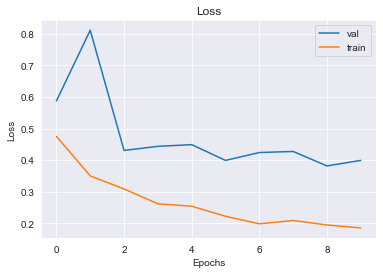

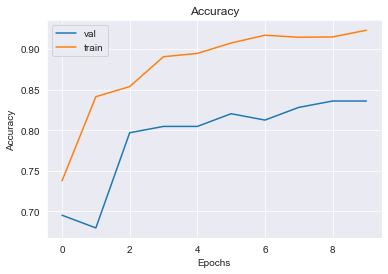

In [62]:
visualize_training_results(results_3)

In [63]:
test_loss, test_score = model_3.evaluate(test_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)    

511/511 [==============================] - 5s 10ms/step - loss: 0.2745 - accuracy: 0.8924
Loss on test set:  0.27445417642593384
Accuracy on test set:  0.8923678994178772


In [64]:
test_loss, test_score = model_3.evaluate(val_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)    

5/5 [==============================] - 1s 157ms/step - loss: 0.3966 - accuracy: 0.8372
Loss on test set:  0.39663809537887573
Accuracy on test set:  0.8372092843055725


The learning curves are a bit more sporadic, similar to the baseline; however, there still appears to be an improvement in terms of loss and accuracy. Again the model might be overfitting to the training data since it's accuracy increases to almost 93% but falls for the validation and test data.

### Transfer Learning

For the final model, Residual Networks ([ResNet](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)) was chosen due to it's popularity and ability to train extremely deep neural networks successfully. It is a classic neural network used for many computer vision tasks. There are different variants of ResNet based on different architecture and the number of layers. I chose ResNet50, which is 50 layers deep convolutional network and is a more advanced variant of the ResNet34 and has been shown to improve accuracy and lesser training time. There also other variants such as ResNet101 and ResNet152.

With the ResNet50 architecture, I opted to include Global Average Pooling, which computes the average value of all values across the entire matrix for each input channel and Dropout prior to the output layer, which randomly sets the the input units to 0 at each step during training to help prevent overfitting. 

In [45]:
def resnet_1():
    base_model = ResNet50(include_top=False, #utilize keras resnet50 architecture
                         weights=None,
                         input_shape=(200, 200, 1))
    X = base_model.output #takes output of last convolution block in resnet50
    X = GlobalAveragePooling2D()(X) 
    X = Dropout(.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs= base_model.input, outputs = X)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [46]:
model_4 = resnet_1()

In [47]:
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [48]:
results_4 = model_4.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        steps_per_epoch=step_size_train,
                        validation_steps=step_size_val,
                        class_weight=cw,
                        callbacks=[early_stop, learning_rate_reduc])

Epoch 1/10
163/163 [==============================] - 1217s 7s/step - loss: 0.4528 - accuracy: 0.8313 - val_loss: 5.1726 - val_accuracy: 0.6172
Epoch 2/10
163/163 [==============================] - 1070s 7s/step - loss: 0.2519 - accuracy: 0.8924 - val_loss: 4.6813 - val_accuracy: 0.6172
Epoch 3/10
163/163 [==============================] - 1812s 11s/step - loss: 0.2456 - accuracy: 0.9013 - val_loss: 5.8123 - val_accuracy: 0.6172
Epoch 4/10
163/163 [==============================] - 1978s 12s/step - loss: 0.2350 - accuracy: 0.9041 - val_loss: 3.2529 - val_accuracy: 0.4375
Epoch 5/10
163/163 [==============================] - 1913s 12s/step - loss: 0.2221 - accuracy: 0.9068 - val_loss: 0.9652 - val_accuracy: 0.5391
Epoch 6/10
163/163 [==============================] - 1901s 12s/step - loss: 0.2181 - accuracy: 0.9093 - val_loss: 0.6930 - val_accuracy: 0.6484
Epoch 7/10
163/163 [==============================] - 1870s 11s/step - loss: 0.1915 - accuracy: 0.9285 - val_loss: 0.7843 - val_accu

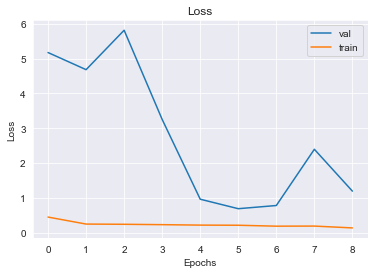

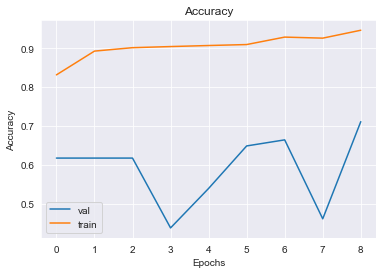

In [51]:
visualize_training_results(results_4)

In [52]:
test_loss, test_score = model_4.evaluate(test_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)  

511/511 [==============================] - 37s 72ms/step - loss: 0.9695 - accuracy: 0.7299
Loss on test set:  0.9695360064506531
Accuracy on test set:  0.7299413084983826


In [53]:
test_loss, test_score = model_4.evaluate(val_gen, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score) 

5/5 [==============================] - 6s 1s/step - loss: 1.1875 - accuracy: 0.7132
Loss on test set:  1.187495470046997
Accuracy on test set:  0.713178277015686


The ResNet50 model took much longer to fit on the data. The results show it is overfit. It probably requires more tuning to get a better performing model.

## Evaluation

Even though the goal was not to find the best performing model, the iterative process helped me understand how complex neural networks and image classification can get.

This section evaluates the models more thoroughly and explains how these findings can help our business understanding.

In [147]:
#setting my y_test and resetting the image generator to evaluate
y_test = test_gen.classes
test_gen.reset()

In [138]:
#https://newbedev.com/how-to-use-predict-generator-on-new-images-keras
#https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

#getting the predictions for the 2nd model (shallow CNN)
predictions_1 = model_2.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred_1 = np.rint(predictions_1)

In [139]:
#metrics
print("Test Accuracy: ", accuracy_score(y_test, y_pred_1))
print(metrics.classification_report(y_test, y_pred_1, labels=[0, 1]))

Test Accuracy:  0.8669275929549902
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       193
           1       0.86      0.94      0.90       318

    accuracy                           0.87       511
   macro avg       0.87      0.84      0.85       511
weighted avg       0.87      0.87      0.86       511



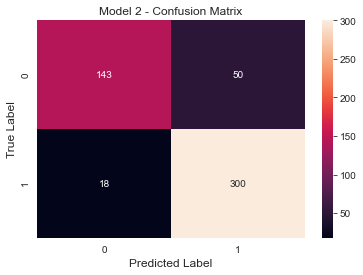

In [142]:
cm = metrics.confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm, annot=True, fmt='g')

plt.title('Model 2 - Confusion Matrix')
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [144]:
#getting the predictions for the 3rd model (deeper CNN)
predictions_2 = model_3.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred_2 = np.rint(predictions_2)

In [145]:
#metrics
print("Test Accuracy: ", accuracy_score(y_test, y_pred_2))
print(metrics.classification_report(y_test, y_pred_2, labels=[0, 1]))

Test Accuracy:  0.8923679060665362
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       193
           1       0.90      0.93      0.91       318

    accuracy                           0.89       511
   macro avg       0.89      0.88      0.88       511
weighted avg       0.89      0.89      0.89       511



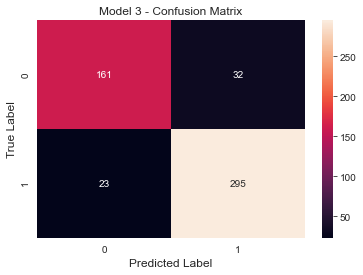

In [146]:
cm = metrics.confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm, annot=True, fmt='g')

plt.title("Model 3 - Confusion Matrix")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [148]:
#predictions for the final model (ResNet50)
predictions_3 = model_4.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred_3 = np.rint(predictions_3)

In [149]:
#metrics
print("Test Accuracy: ", accuracy_score(y_test, y_pred_3))
print(metrics.classification_report(y_test, y_pred_3, labels=[0, 1]))

Test Accuracy:  0.7299412915851272
              precision    recall  f1-score   support

           0       1.00      0.28      0.44       193
           1       0.70      1.00      0.82       318

    accuracy                           0.73       511
   macro avg       0.85      0.64      0.63       511
weighted avg       0.81      0.73      0.68       511



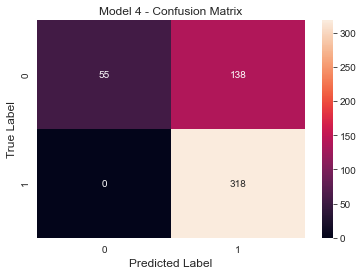

In [150]:
cm = metrics.confusion_matrix(y_test, y_pred_3)
sns.heatmap(cm, annot=True, fmt='g')

plt.title('Model 4 - Confusion Matrix')
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

Due to the nature of this business problem, it is fairly safe to assume that it would be better to have more false positives rather than false negatives. In other words, diagnosing someone with pneumonia when they ultimately did not would be preferable to missing a patient who has pneumonia but were diagnosed as negative/normal. It could potentially be more "costly" to have false negatives.

In relation to the metrics and confusion matrix, precision and recall are the more basic evaluation metrics and have an inverse relationship. I believe in this case, it is preferable to have a higher recall score compared to precision because with higher recall, the model is more likely to classify an image as with pneumonia rather than having a higher threshold to correctly identify images with pneumonia. 
Accuracy and F1 score are a bit more informative in terms of the model's performance. F1 scores are the harmonic mean of precision and recall. I chose to focus on accuracy since is a more common metric for classification and measures the total number of predictions a model gets right. Model 2 and 3 have similar accuracy scores, with the deeper CNN having a slightly better score of 0.89. These two models also have very similar recall scores at 0.94 and 0.93, which is pretty good. Even though the ResNet50 model had a similar accuracy to the baseline at 0.73, it had a higher recall score. 

As mentioned, when comparing false positives and false negatives, it would be better to have more false positives and minimize false negatives. This is shown in all the confusion matrices, but the most is showcased in the last model, ResNet50. Overall, as seen through each iteration, by adding more layers and in return, adding more complexity, the weights in the network increase and are able to extract more features. However, adding more layers isn't always the answer. It is heavily dependent on the data. With more tuning, there would probably be a better performing model.

From this initial analysis, it is apparent that image classification can be complex especially with large sets of data and therefore, be computationally expensive. However, with the time and scope of this project, I was able to examine and understand deep learning and neural networks better in the context of x-ray image classification in the medical field. It is possible to utilize AI in helping our understanding of classification, and I know it will continue to grow in the health and medical space. As more and more data is available, and deeper models such as ResNet can be tuned to learn more efficiently, it will only increase performance and proper diagnosis. This increased understanding can help medical personnel in not only efficiency but parameters of diagnosis such as patterns we may not be able to notice. This can also help broaden our scope to other sectors of help.

### Next Steps

Through this iterative process, a few things to be considered for future exploration:

- There are many parameters that could've been tuned or incorporated in the preprocessing steps and models. Our understanding of these additional iterations can continue to inform the use case and business problem.
- The x-rays in this dataset were of pediatric patients. It would be interesting to see how this process and these models would perform with a different dataset or a more diverse dataset such as including adults.
- Many have utilized neural networks to classify x-ray images, it would informative to dig more into models that have been shown to be successful and collaborate. 